# E[15] 프로젝트: 한국어 데이터로 챗봇 만들기

## Step 1. 데이터 수집하기

## Step 2. 데이터 전처리하기
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

## Step 3. SubwordTextEncoder 사용하기
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

## Step 4. 모델 구성하기
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

## Step 5. 모델 평가하기
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

## 1. 데이터 수집하기

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("슝=3")

슝=3


### 어텐션
* Query: 찾고자 하는 대상
* Key: 저장된 데이터를 찾고자 할 때 참조하는 값
* Value: 저장된 데이터

  * Query와 Key가 유사한지 비교하고, 유사도를 고려한 Value값을 섞어서 Aggregation(합성)해준 결과가 Attention value임
  * 즉 Q에 대해 어떤 K가 유사한지 비교하고, 유사도를 반영하여 V들을 합성한 것

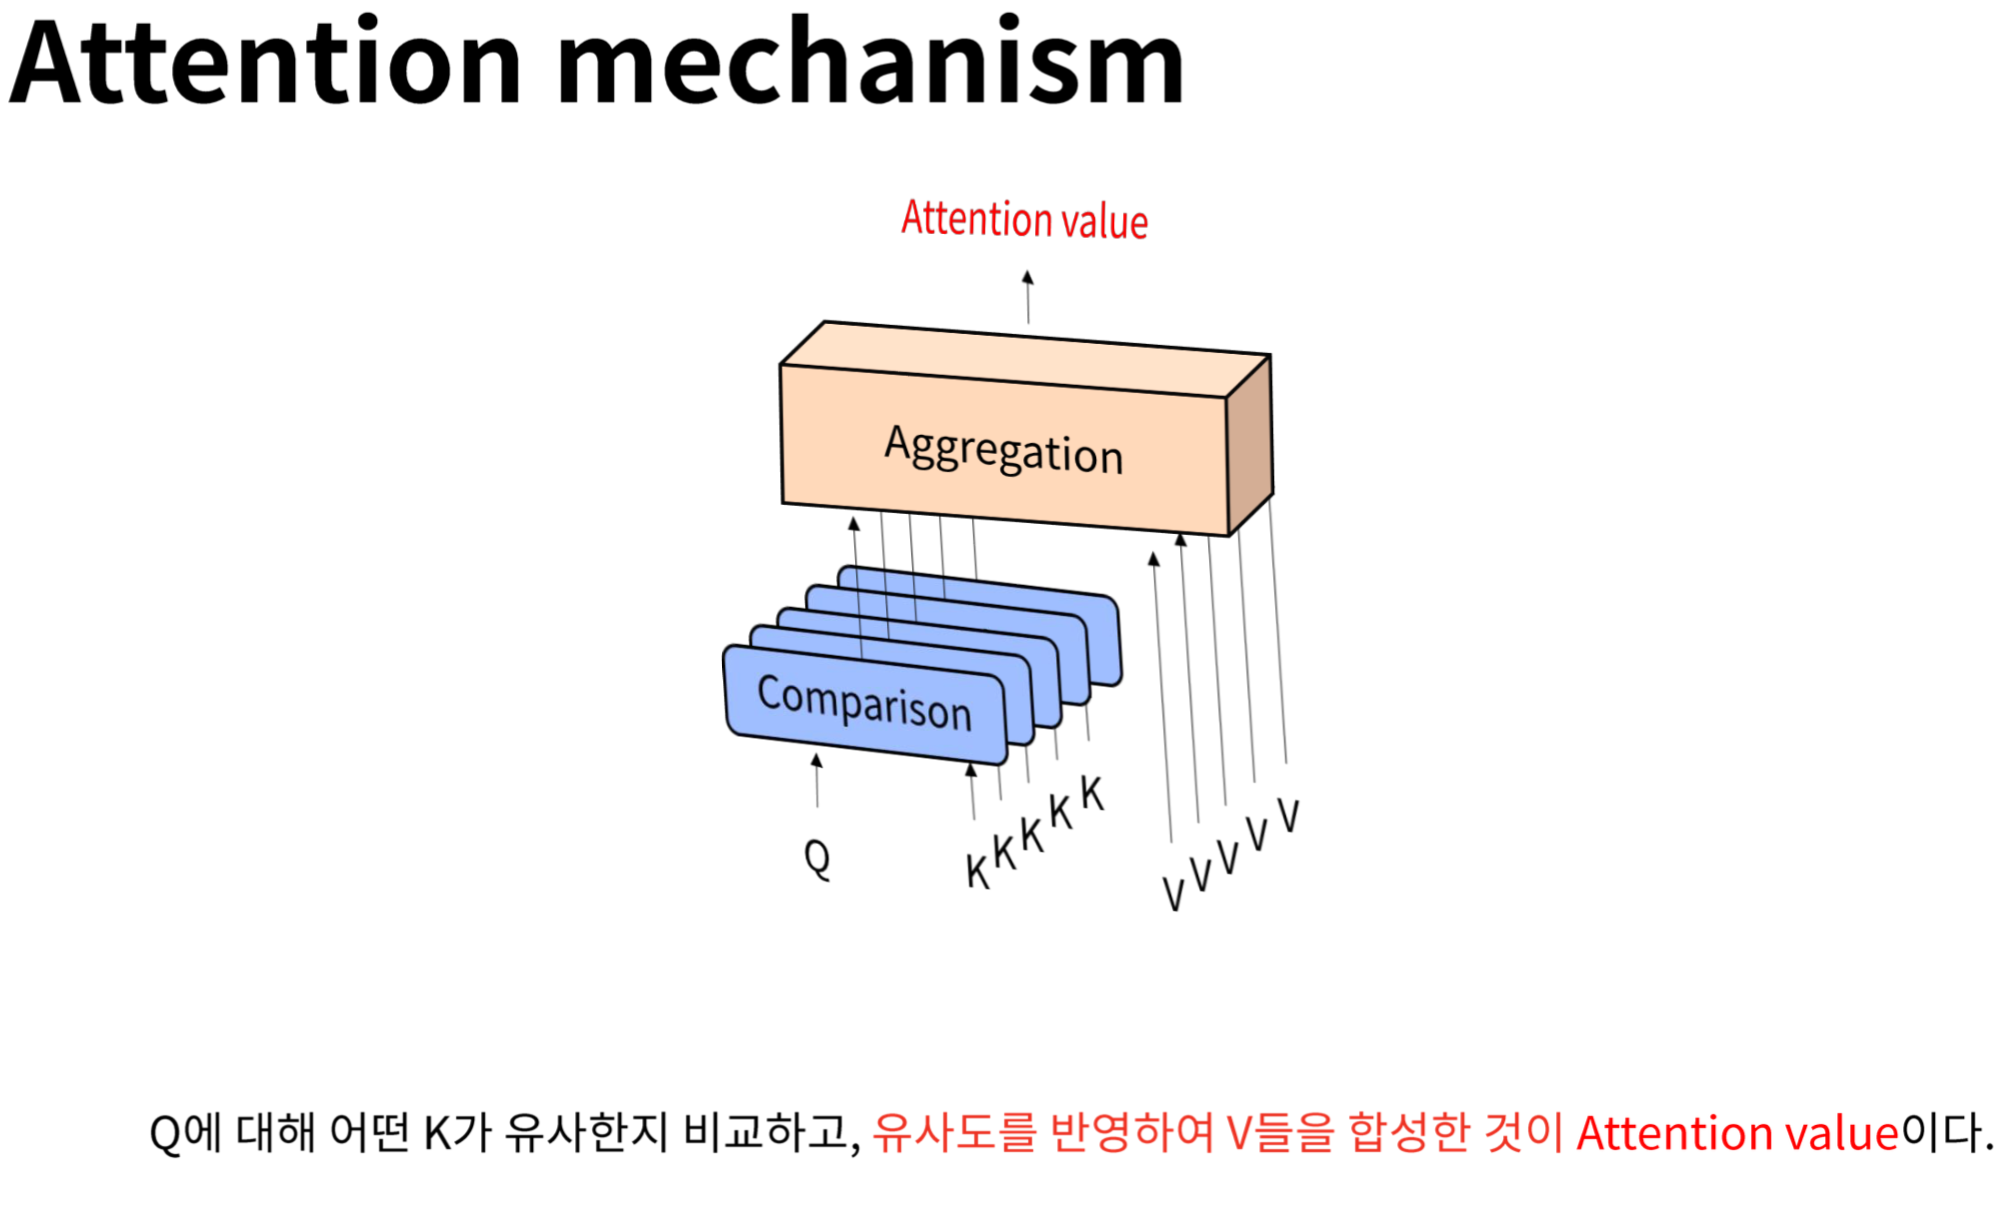

### 1-1. 챗봇의 병렬 데이터 받아오기

In [4]:
data = pd.read_csv(os.getenv('HOME')+'/ChatbotData .csv')
data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [5]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 10000
print(MAX_SAMPLES)

10000


## 2. 데이터 전처리

### 2-1. 영어, 한글, 숫자, 구두점을 제외한 데이터 전처리

In [6]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    # sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = re.sub(r"[^ ㄱ-ㅣ가-힣a-zA-z0-9?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence
print("슝=3")

슝=3


In [7]:
preprocess_sentence("PPL 심하네 눈살이 찌푸려지죠.")

'ppl 심하네 눈살이 찌푸려지죠 .'

### 1-2. 전처리 진행 함수 호출

#### 데이터 확인

In [8]:
print(data.shape)
print(data['Q'][1])
print(data['A'][1])

(11823, 3)
1지망 학교 떨어졌어
위로해 드립니다.


In [9]:
# def load_conversations():
#     questions = {}
#     answers = {}
#     q = []
#     a = []
#     for n, z in enumerate(zip(data['Q'], data['A'])):
#         #     print(n)
#         #     print(z[0])
#         #     print(z[1])
#         questions[n] = preprocess_sentence(questions[z[0]])
#         answers[n] = preprocess_sentence(answers[z[1]])
#         q.append(questions[n])
#         a.append(answer[n])
#     return q, a
# print(q)
# print(a)

In [10]:
def load_conversations():
    q = []
    a = []
    for n, z in enumerate(zip(data['Q'], data['A'])):
        
        q.append(preprocess_sentence(data['Q'][n]))
        a.append(preprocess_sentence(data['A'][n]))
    return q, a
# print(q)
# print(a)

#### 샘플 수 확인

In [11]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [12]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


## 3. Tokenizer(SubwordTextEncoder) 생성

### 3-1. 단어장(Vocabulary) 만들기

In [13]:
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.2.0 이하)
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

# (주의) Tensorflow 2.3.0 이상의 버전에서는 아래 주석의 코드를 대신 실행해 주세요. 
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [14]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


#### 시작 토큰과 종료 토큰에 부여된 정수를 출력

In [15]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8171]
END_TOKEN의 번호 : [8172]


In [16]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8173


### 3-2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

* tokenizer.encode()로 각 단어를 정수로 변환
* tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환

In [17]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5761, 610, 2491, 4163]
정수 인코딩 후의 21번째 답변 샘플: [2357, 7511, 7, 6274, 97, 1]


In [18]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


### 3-3. 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩하는 함수 구현

In [19]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    # 최대 길이 40으로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [20]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8173
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


#### 교사강요
질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3
